# Global fit to all three K2 campaign lightcurves

July 2019 MGS

with ASASSN and for all campaigns with PSD analysis.

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from astropy.stats import LombScargle
import astropy.units as u
from astropy.time import Time

In [3]:
import celerite
from celerite import terms

# subsub K2

In a previous notebook, we made detrended lightcurves with the lightkurve implementation of SFF and saved them to csv files locally.  We'll read those back in as DataFrames.

In [4]:
dfC05 = pd.read_csv('../data/K2/S1063_K2_C05_lightkurve_SFF.csv')
dfC05['Campaign'] = 5
dfC16 = pd.read_csv('../data/K2/S1063_K2_C16_lightkurve_SFF.csv')
dfC16['Campaign'] = 16
dfC18 = pd.read_csv('../data/K2/S1063_K2_C18_lightkurve_SFF.csv')
dfC18['Campaign'] = 18

In [5]:
# Here we retroactively assign the campaign zeropoints, which are not known a-priori.
C05_const, C16_const, C18_const = 76956.4/1.025, 73136.2, 77089.98/1.065 # iteratively computed at bottom.

In [6]:
dfC05['flux'] = dfC05['flux'] / C05_const
dfC16['flux'] = dfC16['flux'] / C16_const
dfC18['flux'] = dfC18['flux'] / C18_const

#df = pd.concat([dfC05, dfC16, dfC18], ignore_index=True)
df = pd.concat([dfC16], ignore_index=True)

# df['flux'] = df.flux / np.percentile(df.flux, 98) Turn of if you normalize campaigns separately!
df['flux_err'] = df.flux *0.005

In [7]:
df['t_sec'] = (df.time.values*u.day).to(u.second).value

In [8]:
over_sample=10

## Celerite modeling

In [9]:
guess_period = (23.5 * u.day).to(u.second).value
guess2_period = (12.5 * u.day).to(u.second).value
variance = np.var(df.flux.values)

#### A periodic term

In [10]:
Q_guess = 25.0
w0_guess = 2.0*np.pi / guess_period
S0_guess = variance * 30000.0

bounds1 = dict(log_S0=(-0.5, 8.7), log_Q=(1.09, 3.9), log_omega0=(-12.95, -12.44))

kernel_sho = terms.SHOTerm(log_S0=np.log(S0_guess), log_Q=np.log(Q_guess), 
                       log_omega0=np.log(w0_guess), bounds=bounds1)

#### A random walk term

In [11]:
t_char = (0.05*u.year).to(u.second)
c_val = 2.0*np.pi * 1/(t_char)
a_val = c_val*2e1

In [12]:
bounds_rw = dict(log_c=(-14.7, -10.1), log_a=(-14.0, -4.8))
true_logc, true_loga = np.log(c_val.value) , np.log(a_val.value)
kernel_drw = terms.RealTerm(log_a=true_loga, log_c=true_logc, bounds=bounds_rw)

#### A second periodic term

In [13]:
guess_period2 = (12.5 * u.day).to(u.second).value

In [14]:
Q2_guess = 19.0
w02_guess = 2.0*np.pi / guess_period2
S02_guess = variance * 5000.0

bounds_sho2 = dict(log_S0=(-2.0, 7.1), log_Q=(0.69, 3.2), log_omega0=(-12.40, -11.1))

kernel_sho2 = terms.SHOTerm(log_S0=np.log(S02_guess), log_Q=np.log(Q2_guess), 
                       log_omega0=np.log(w02_guess), bounds=bounds_sho2)

#### A long-term trend term

In [15]:
long_term_turnover = 0.5 * u.year.to(u.second)
Q3_fixed = 1.0/np.sqrt(2)
w03_guess = 2.0*np.pi / long_term_turnover
S03_guess = variance * 4000000.0

bounds_lt = dict(log_S0=(2.5, 11.7), log_Q=(-0.347573, -0.345574), log_omega0=(-17.0, -13.1))

kernel_sho3 = terms.SHOTerm(log_S0=np.log(S03_guess), log_Q=np.log(Q3_fixed), 
                       log_omega0=np.log(w03_guess), bounds=bounds_lt)

#### A Jitter term 

In [16]:
log_sig = np.log(0.00200)

In [17]:
bounds_jit = dict(log_sigma=(-10.4, -4.6))
kernel_jit = terms.JitterTerm(log_sigma=log_sig, bounds = bounds_jit)

In [18]:
net_kernel = kernel_sho + kernel_drw + kernel_sho2 + kernel_sho3 + kernel_jit
gp = celerite.GP(net_kernel, fit_mean=True, mean=0.95)
gp.compute(df.t_sec.values)

In [19]:
f = np.fft.rfftfreq(len(df)*over_sample, df['t_sec'][1] - df['t_sec'][0])[1:-1]
time_baseline = df.t_sec.iloc[-1] - df.t_sec.iloc[0]
NN = len(df)

In [20]:
power_true = net_kernel.get_psd(2*np.pi*f) / (0.5 * time_baseline)
power_sho = kernel_sho.get_psd(2*np.pi*f) / (0.5 * time_baseline)
power_drw = kernel_drw.get_psd(2*np.pi*f) / (0.5 * time_baseline)
power_sho2 = kernel_sho2.get_psd(2*np.pi*f) / (0.5 * time_baseline)
power_sho3 = kernel_sho3.get_psd(2*np.pi*f) / (0.5 * time_baseline)
power_jit = kernel_jit.jitter * NN * np.ones(len(f)) / (0.5 * time_baseline)

power_post = gp.kernel.get_psd(2*np.pi*f) / (0.5 * time_baseline)

In [21]:
df.flux = gp.sample()

In [22]:
df['t_sec'] = (df.time.values*u.day).to(u.second).value
df_PSD = pd.DataFrame()

for campaign in [5, 16, 18, -1]:
    this_df = df[df.Campaign == campaign].reset_index(drop=True)
    if campaign == -1:
        this_df = df
    this_PSD = pd.DataFrame()
    this_PSD['freq'] = np.fft.rfftfreq(len(this_df)*over_sample, 
                                       (df['t_sec'][1] - df['t_sec'][0]))[1:-1]
    this_PSD['PSD'] = this_PSD['freq']*0

    model = LombScargle(this_df.t_sec.values, this_df.flux.values)
    power_ls = model.power(this_PSD['freq'].values, method="cython", normalization="psd") / len(this_df)

    this_PSD['PSD'] = power_ls
    this_PSD['Campaign'] = campaign
    df_PSD = df_PSD.append(this_PSD, ignore_index=True)

/Users/obsidian/anaconda3/envs/subsub/lib/python3.6/site-packages/numpy/fft/helper.py:226: RuntimeWarning: divide by zero encountered in double_scalars
  val = 1.0/(n*d)
/Users/obsidian/anaconda3/envs/subsub/lib/python3.6/site-packages/numpy/fft/helper.py:229: RuntimeWarning: invalid value encountered in multiply
  return results * val
/Users/obsidian/anaconda3/envs/subsub/lib/python3.6/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/main.py:216: RuntimeWarning: invalid value encountered in double_scalars
  PLS = METHODS[method](*args, **kwds)


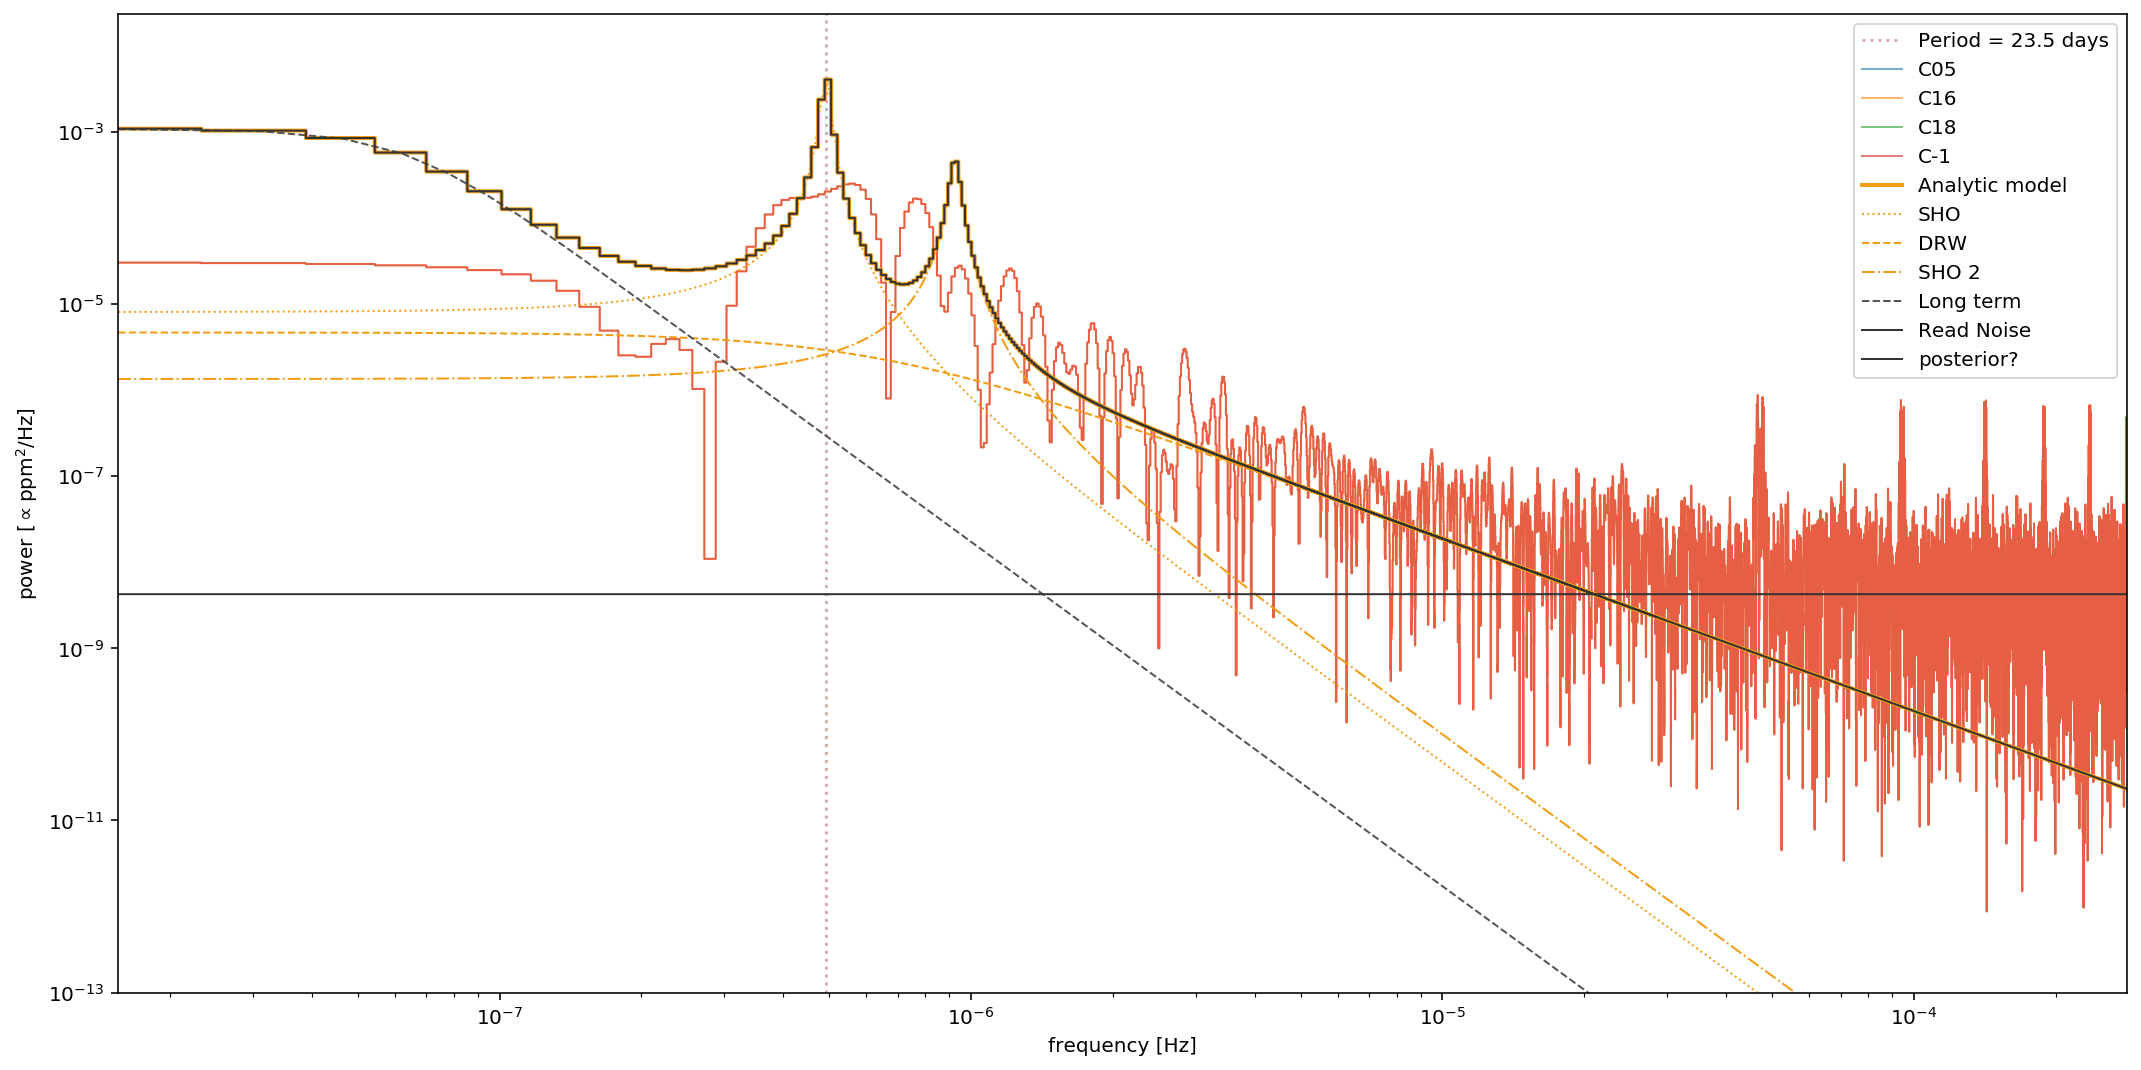

In [23]:
plt.figure(figsize=(18,9))

plt.axvline(1.0/guess_period, color='#ddaaaa', linestyle='dotted', label='Period = 23.5 days', alpha=1)

for campaign in [5, 16, 18, -1]:
    mask = df_PSD.Campaign == campaign
    plt.step(df_PSD['freq'][mask], df_PSD['PSD'][mask], label="C{:02d}".format(campaign), 
             where='mid', alpha=0.6, lw=1)

plt.step(f, power_true, color='#f39c12', lw=2,label="Analytic model", where='mid')
plt.plot(f, power_sho, ':', color='#f39c12', lw=1,label="SHO")
plt.plot(f, power_drw, '--', color='#f39c12', lw=1,label="DRW")
plt.plot(f, power_sho2, '-.', color='#f39c12', lw=1,label="SHO 2")
plt.plot(f, power_sho3, '--', color='#555555', lw=1,label="Long term")
plt.plot(f, power_jit, '-', color='#333333', lw=1,label="Read Noise")

plt.step(f, power_post, color='#333333', lw=1,label="posterior?", where='mid')

#plt.plot(f_highres, power_hires, '--', color='#d35400', lw=1,label="Over sampled", alpha=0.4)

plt.yscale("log")
plt.xscale("log")
plt.xlim(f.min(), f.max())
plt.ylabel("power [$\propto \mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")
plt.ylim(1e-13)

plt.legend(loc='best')
#plt.savefig('../results/subsub_PSD_celerite_model.png', dpi=300, bbox_inches='tight')

In [24]:
%%time
y_many = gp.sample(size=1000)

power_ls = []
for y0 in y_many:
    model = LombScargle(df.t_sec.values, y0)
    power_ls.append(model.power(f[1:-1], method="fast", normalization="psd"))
power_ls = np.array(power_ls)

CPU times: user 47.6 s, sys: 10.4 s, total: 58 s
Wall time: 14.7 s


In [25]:
power_ls /= len(df)

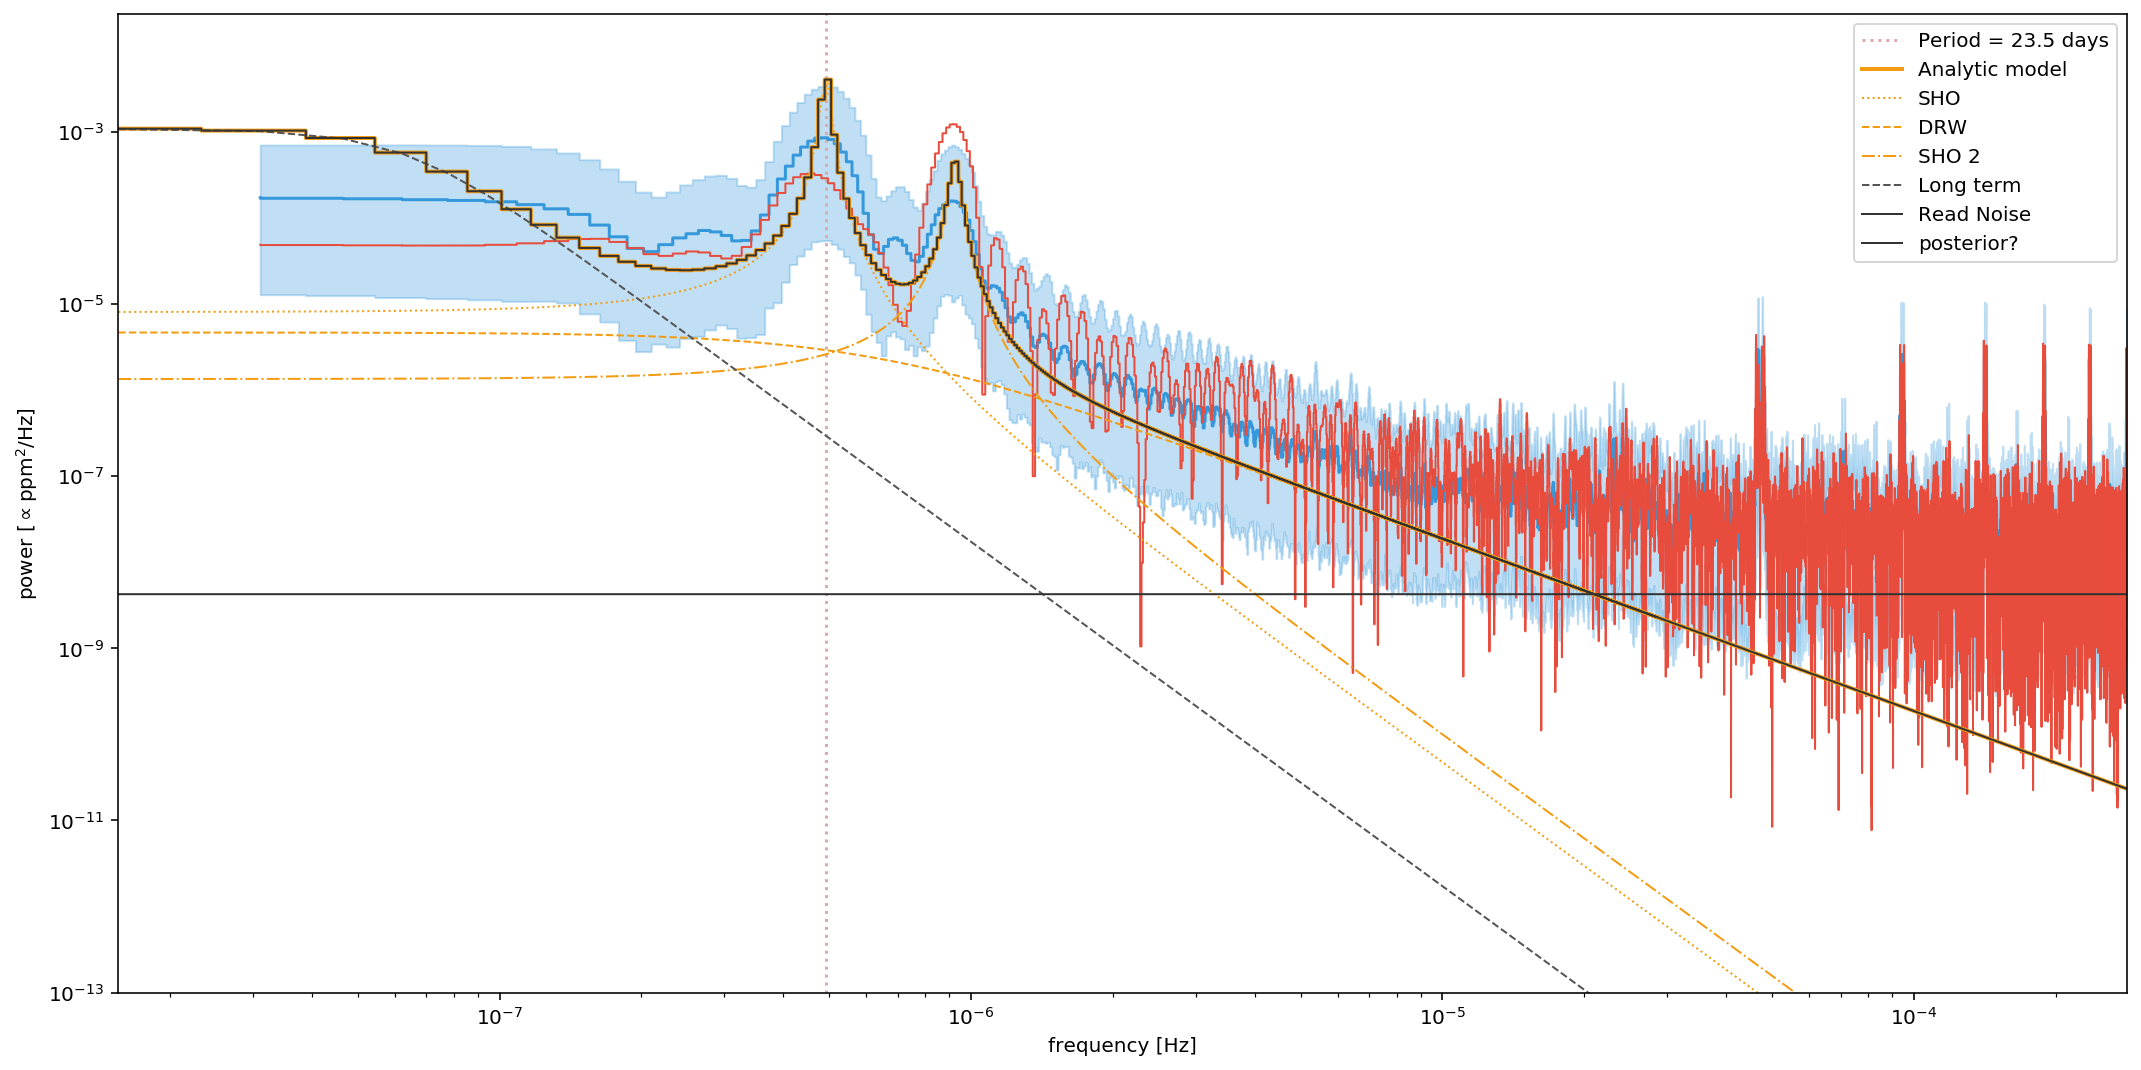

In [26]:
plt.figure(figsize=(18,9))
plt.axvline(1.0/guess_period, color='#ddaaaa', linestyle='dotted', label='Period = 23.5 days', alpha=1)

#for campaign in [5, 16, 18, -1]:
#    mask = df_PSD.Campaign == campaign
#    plt.step(df_PSD['freq'][mask], df_PSD['PSD'][mask], label="C{:02d}".format(campaign), 
#             where='mid', alpha=0.3, lw=1)

plt.step(f[1:-1], np.percentile(power_ls, 50, axis=0), color='#3498db')
plt.fill_between(f[1:-1], np.percentile(power_ls, 5, axis=0),
                 np.percentile(power_ls, 95, axis=0), alpha=0.3,
                 color='#3498db', step='mid')

ii = np.random.randint(0,999)
plt.step(f[1:-1], power_ls[ii, :], color='#e74c3c', alpha=1, lw=1)

plt.step(f, power_true, color='#f39c12', lw=2,label="Analytic model", where='mid')
plt.plot(f, power_sho, ':', color='#f39c12', lw=1,label="SHO")
plt.plot(f, power_drw, '--', color='#f39c12', lw=1,label="DRW")
plt.plot(f, power_sho2, '-.', color='#f39c12', lw=1,label="SHO 2")
plt.plot(f, power_sho3, '--', color='#555555', lw=1,label="Long term")
plt.plot(f, power_jit, '-', color='#333333', lw=1,label="Read Noise")

plt.step(f, power_post, color='#333333', lw=1,label="posterior?", where='mid')

#plt.plot(f_highres, power_hires, '--', color='#d35400', lw=1,label="Over sampled", alpha=0.4)

plt.yscale("log")
plt.xscale("log")
plt.xlim(f.min(), f.max())
plt.ylabel("power [$\propto \mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")
plt.ylim(1e-13)

plt.legend(loc='best')
#plt.savefig('../results/subsub_PSD_celerite_model.png', dpi=300, bbox_inches='tight')

Nice!  Looks solid.

## MCMC Sample!

In [27]:
#y = df.flux.values

In [28]:
y = gp.sample()

In [29]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y) + lp

In [30]:
import emcee

In [31]:
initial = gp.get_parameter_vector()
nparams = len(initial)

In [32]:
ndim, nwalkers = nparams, 40
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)

In [33]:
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)

In [34]:
%%time
p0, lp, _ = sampler.run_mcmc(p0, 5000)

CPU times: user 13.8 s, sys: 1.81 s, total: 15.6 s
Wall time: 48.1 s


In [35]:
names = ['t'+name[12:] for name in gp.get_parameter_names()]
names[-1] = 'mean'

In [36]:
sampler.chain.T.shape

(13, 5000, 40)

In [37]:
sampler.chain.shape

(40, 5000, 13)

CPU times: user 447 ms, sys: 59 ms, total: 506 ms
Wall time: 503 ms


Text(0.5, 0, 'step number')

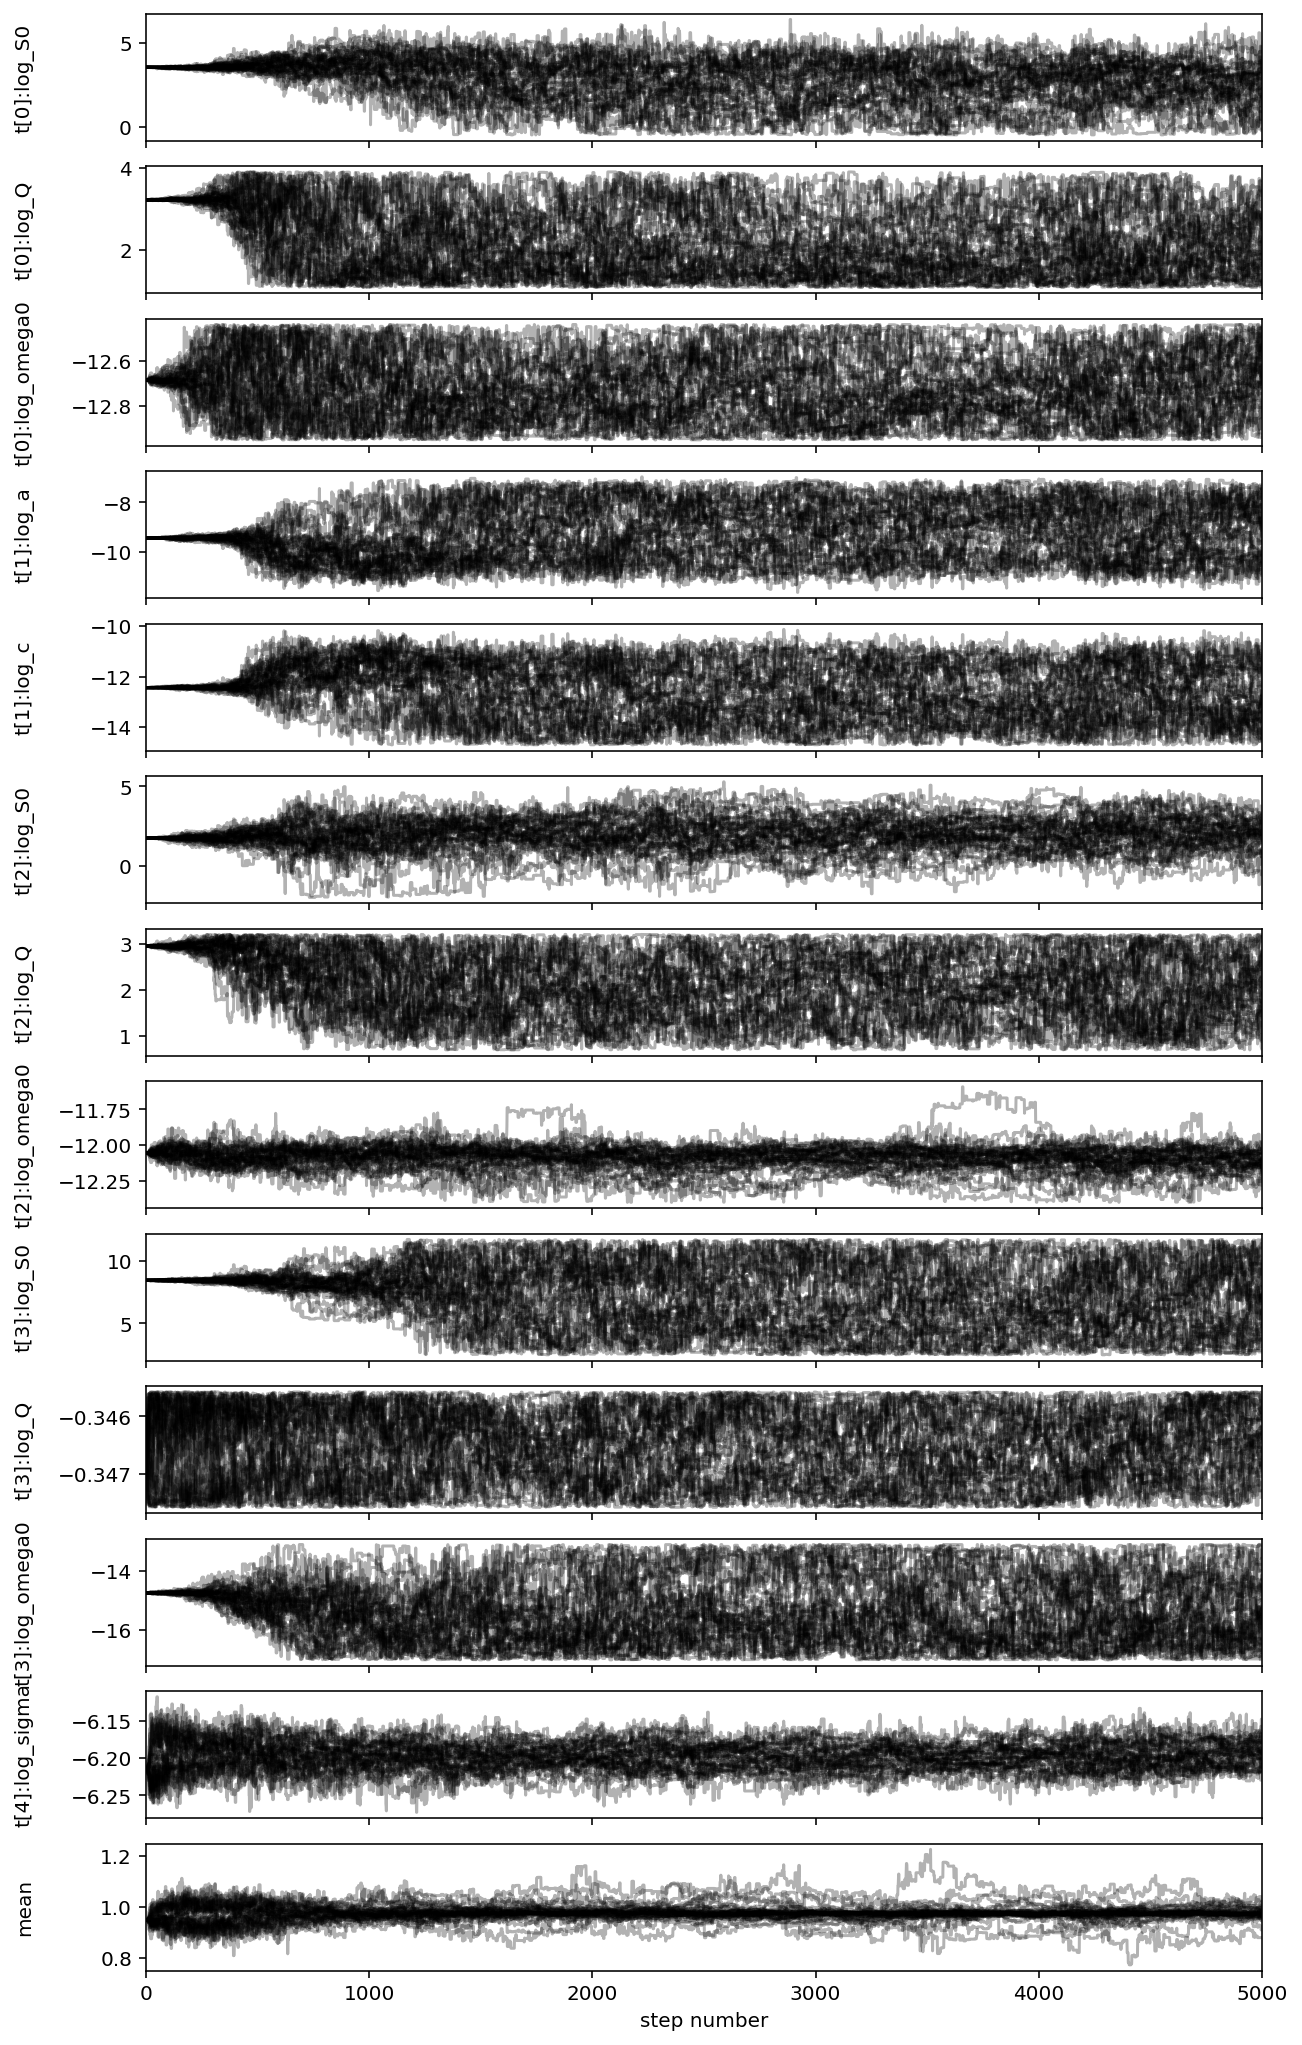

In [38]:
%%time
fig, axes = plt.subplots(nparams, figsize=(10, 18), sharex=True)
samples = sampler.chain
labels = names
for i in range(nparams):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
    ax.set_xlim(0, 5000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Play with simulated data.

In [59]:
model = LombScargle(t, y)
power_draw = model.power(f[1:-1], method="cython", normalization="psd") / NN

In [56]:
y_many = gp.sample(size=1000)

In [58]:
%%time
power_ls = []
for y0 in y_many:
    model = LombScargle(t, y0)
    power_ls.append(model.power(f[1:-1], method="fast", normalization="psd"))

power_ls = np.array(power_ls)

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= NN

CPU times: user 1min 9s, sys: 4.17 s, total: 1min 13s
Wall time: 18.8 s


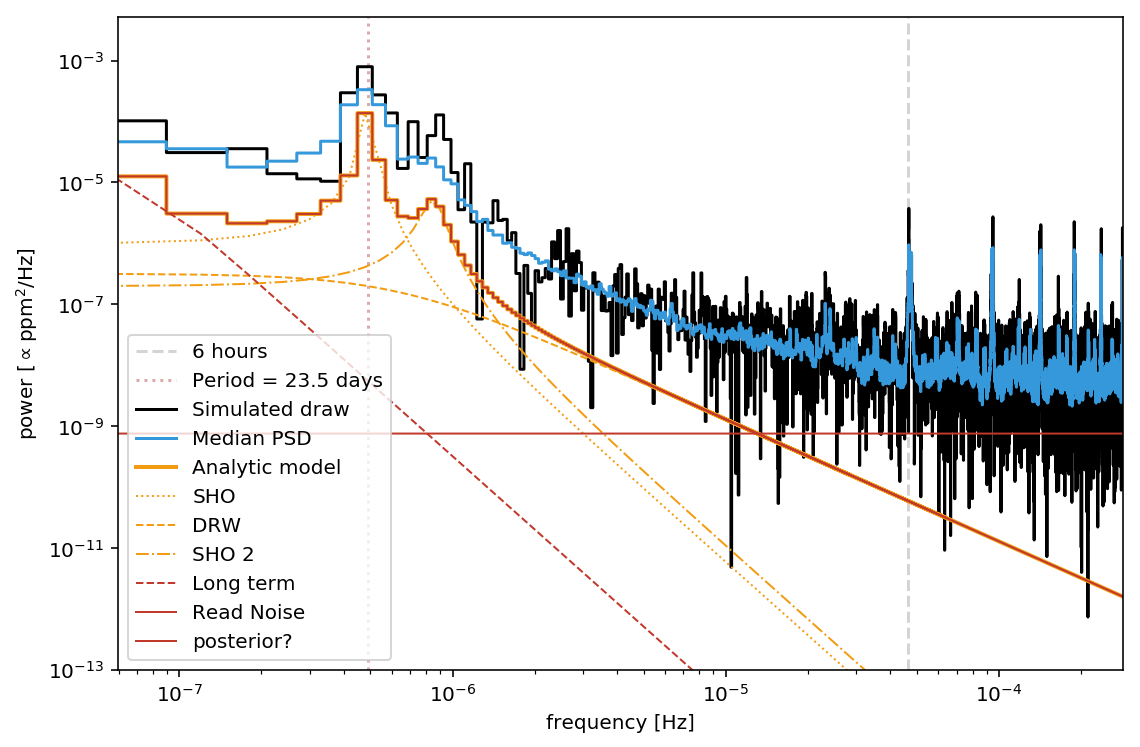

In [63]:
plt.figure(figsize=(9,6))
plt.axvline(1.0/t_motion.value, color='#aaaaaa', linestyle='dashed', label='6 hours', alpha=0.5)

plt.axvline(1.0/guess_period, color='#ddaaaa', linestyle='dotted', label='Period = 23.5 days', alpha=1)

plt.step(f[1:-1], power_draw,label="Simulated draw", color='k', where='mid')

plt.step(f[1:-1], np.median(power_ls, axis=0), label="Median PSD", color='#3498db', where='mid', alpha=1)

plt.step(f, power_true, color='#f39c12', lw=2,label="Analytic model", where='mid')
plt.plot(f, power_sho, ':', color='#f39c12', lw=1,label="SHO")
plt.plot(f, power_drw, '--', color='#f39c12', lw=1,label="DRW")
plt.plot(f, power_sho2, '-.', color='#f39c12', lw=1,label="SHO 2")
plt.plot(f, power_sho3, '--', color='#c0392b', lw=1,label="Long term")
plt.plot(f, power_jit, '-', color='#c0392b', lw=1,label="Read Noise")

plt.step(f, power_post, color='#c0392b', lw=1,label="posterior?", where='mid')

#plt.plot(f_highres, power_hires, '--', color='#d35400', lw=1,label="Over sampled", alpha=0.4)

plt.yscale("log")
plt.xscale("log")
plt.xlim(f[1:].min(), f.max())
plt.ylabel("power [$\propto \mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")
plt.ylim(1e-13)

plt.legend(loc='best')
#plt.savefig('../results/subsub_PSD_celerite_model.png', dpi=300, bbox_inches='tight')

In [50]:
samples[5, 4998, :]

array([  1.54195776,   3.3185561 , -12.70878375, -13.79513154,
       -10.1312116 ,   0.59341742,   2.27693389, -12.00879505,
         5.26091218,  -0.34640213, -14.49487221,  -6.71780598,
         0.96771071])

In [51]:
random_sample = samples[5, 4998, :]

In [52]:
gp.set_parameter_vector(random_sample)

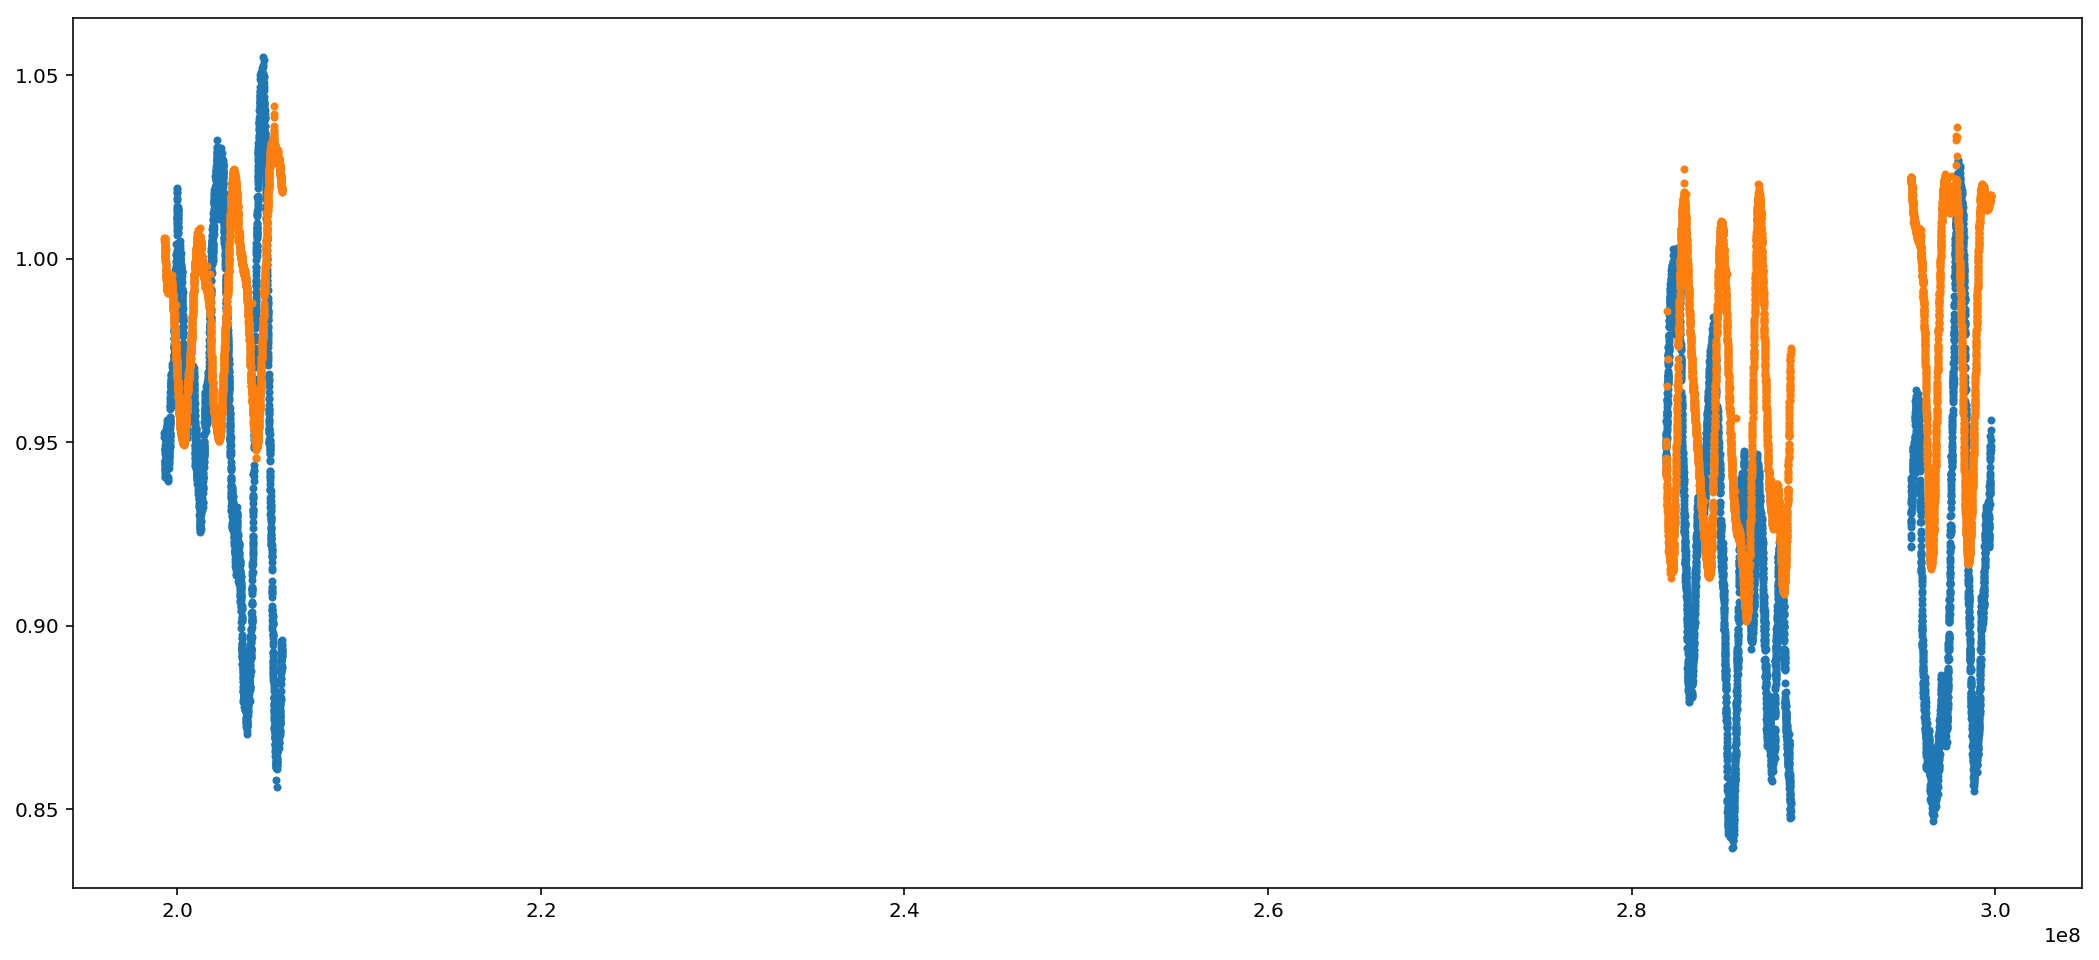

In [59]:
plt.figure(figsize=(18, 8))
plt.plot(t, gp.sample(), '.')
plt.plot(t, df.flux.values, '.')

(0.8, 1.2)

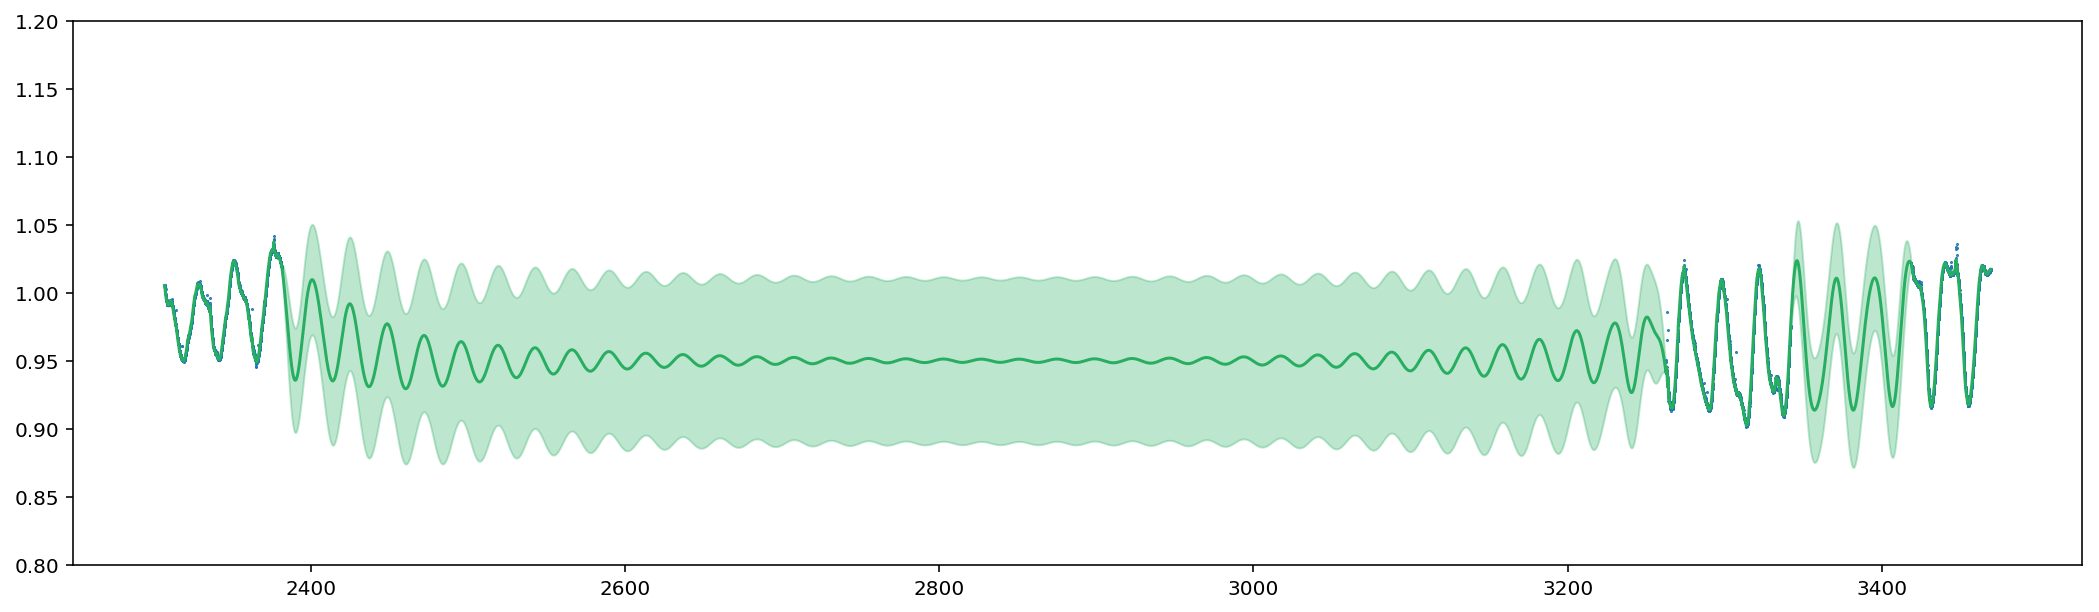

In [60]:
t_dense = np.linspace(t[0], t[-1], num=5000)
mu, var = gp.predict(df.flux.values, t_dense, return_var=True)
std = np.sqrt(var)

plt.figure(figsize=(18,5))
plt.plot(t*u.second.to(u.day), df.flux, '.', ms=1)

plt.plot(t_dense*u.second.to(u.day), mu, color='#27ae60')
plt.fill_between(t_dense*u.second.to(u.day), 
                 mu+std, mu-std, alpha=0.3, color='#27ae60', edgecolor="none")

plt.ylim(0.8, 1.2)

## Now let's apply to the ASASSN data!

In [58]:
df_ASASSN = df_ASASSN.sort_values('time').reset_index(drop=True)

In [60]:
t = df_ASASSN.time.values*u.day.to(u.second)
y = df_ASASSN.flux.values
yerr = df_ASASSN.flux_err.values

<ErrorbarContainer object of 3 artists>

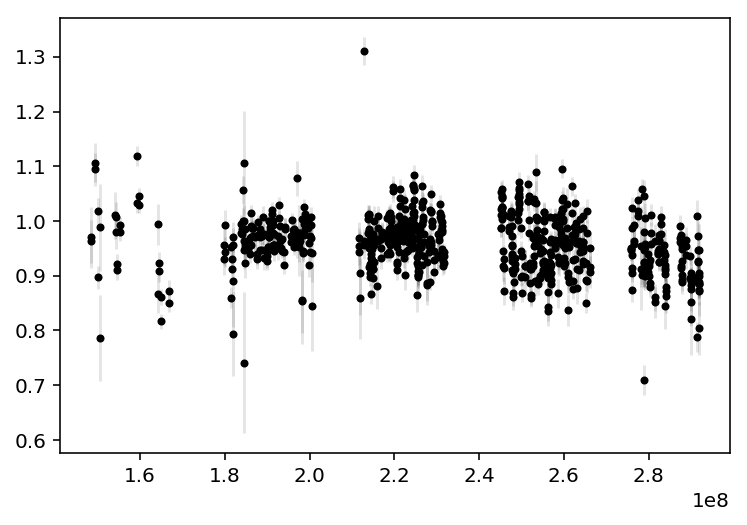

In [61]:
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
#plt.ylim(0.985, 1.0)
#plt.xlim(3272, 3273)


In [62]:
gp.get_parameter_vector()

array([  1.54195776,   3.3185561 , -12.70878375, -13.79513154,
       -10.1312116 ,   0.59341742,   2.27693389, -12.00879505,
         5.26091218,  -0.34640213, -14.49487221,  -6.71780598,
         0.96771071])

In [65]:
gp.compute(t, yerr=yerr)

(0.8, 1.2)

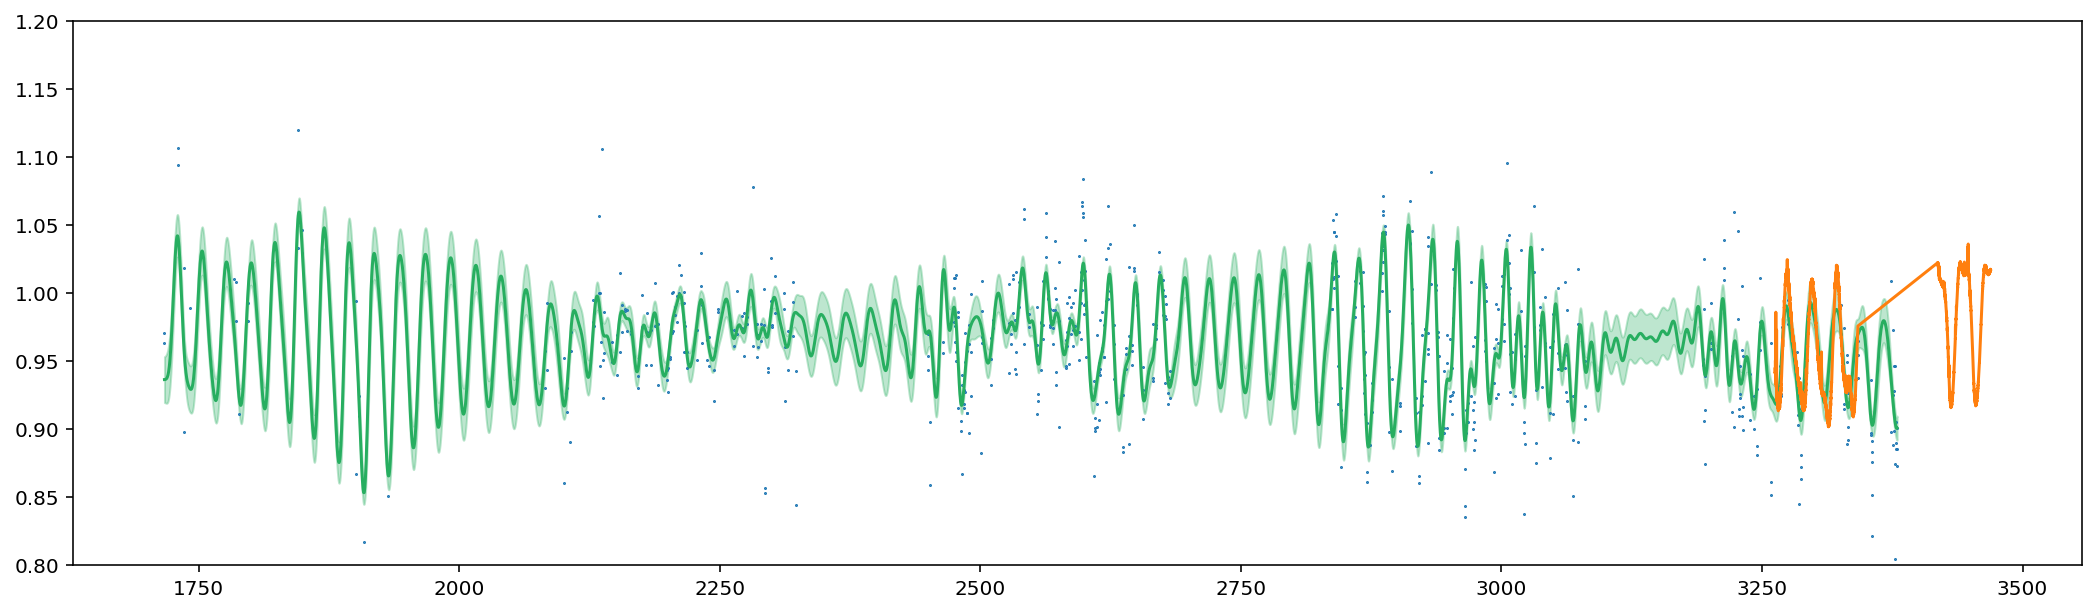

In [67]:
t_dense = np.linspace(t[0], t[-1], num=5000)
mu, var = gp.predict(y, t_dense, return_var=True)
std = np.sqrt(var)

plt.figure(figsize=(18,5))
plt.plot(t*u.second.to(u.day), y, '.', ms=1)

plt.plot(t_dense*u.second.to(u.day), mu, color='#27ae60')
plt.fill_between(t_dense*u.second.to(u.day), 
                 mu+std, mu-std, alpha=0.3, color='#27ae60', edgecolor="none")

plt.plot(df.time, df.flux.values)

plt.ylim(0.8, 1.2)

Meh?